# Procedure for quantum state preparation (QSP) experiment.

QSP is presented clearly in [this publication](https://arxiv.org/abs/2306.17422). The basic idea is that we have two unitary $U(\theta)$ and $V^{\dagger}$, we optimize the parameter $\theta$ until $\theta^{*}$ such that $U(\theta^{*})V^{\dagger}=I$.

So we will do experiments with various $U$, $V^{\dagger}$ and optimize strategy. 

Some notation for hyperparameter:

(important)
- Ansatz: $U$ (defined in `qtm.ansatz`)
- Optimize circuit: $u$ (ansatz when repeat $L$ times)
- State: $V^{\dagger}$ (defined in `qtm.state`)
- Number of qubit: $n$ (`num_qubits`)
- Number of layer (for ansatz): $L$ (`num_layers`)
- $\theta$: theta (if $\theta$ is scalar), thetas (if $\theta$ is 1-d numpy array) and thetass (if $\theta$ is 2-d numpy array).

(not important)
- Number of iteration: $n_{iter}$ (`num_iter / iter`)
- Optimizer: `sgd`, `adam` or `qng` family, the best optimizer is `adam`.

Here is your task, run the below codes with:

- $U$ is `qtm.ansatz.g2`, `qtm.ansatz.g2gn` or `qtm.ansatz.g2gnw`.
- $V^{\dagger}$ is `qtm.state.create_GHZ_state(num_qubits).inverse()`, `qtm.state.create_W_state(num_qubits).inverse()`, `qtm.state.create_AME_state(num_qubits).inverse()` or `qtm.state.create_haar_state_inverse(num_qubits)`
- $n$ from 3 - 10 (3 - 5 for AME state).
- $L$ from 1 - 10 (Note: if we run L = 3 and achieve fidelity ~ 0, then no need to run with larger $L$).
- $n_{iter}$: default is 100, if loss value is not ~ 0, you can plot loss_values curve by compiler.plot() method, if it can decrease in the next iteration, then increasing $n_{iter}$ upto 300.

The detailed guideline is below. If you can use the server A6000, let's view `multi_process_script.py`.

In [58]:
import sys
sys.path.insert(0, '..')
from qsee.compilation.qsp import QuantumStatePreparation
from qsee.core import ansatz, state
from qsee.backend import constant, utilities
import matplotlib.pyplot as plt
import numpy as np, qiskit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Quantum State Preparation (QSP) problem

First, using Quantum Compilation (QC) to find optimized $\theta$

In [125]:
def custom_ansatz(num_qubits: int) -> qiskit.QuantumCircuit:
    qc = qiskit.QuantumCircuit(num_qubits)
    thetas = qiskit.circuit.ParameterVector(
        'theta', 2 * num_qubits)
    j = 0
    for i in range(num_qubits):
        qc.rx(thetas[j], i)
        qc.rz(thetas[j + 1], i)
        j += 2
    return qc
qsp = QuantumStatePreparation(
    u=custom_ansatz(num_qubits = 3),
    target_state=state.w(num_qubits = 3).inverse(),
).fit(
    num_steps = 200, 
    optimizer='sgd', 
    metrics_func = [
        'loss_basic', 
        'compilation_trace_fidelities'
    ]
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


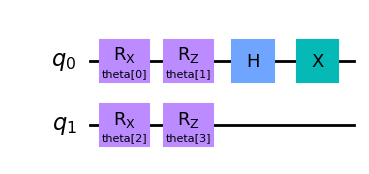

In [116]:
custom_ansatz(num_qubits = 2).compose(state.w(num_qubits = 2).inverse()).draw('mpl', filename = 'circuit.svg')

In [85]:
theta = np.pi / 2
u = np.array(
    [
        [1, 0, 0, 0],
        [0, np.cos(theta), 0, np.sin(theta)],
        [0, 0, 1, 0],
        [0, np.sin(theta), 0, -np.cos(theta)],
    ]
)
compiler = QuantumStatePreparation.prepare(u)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


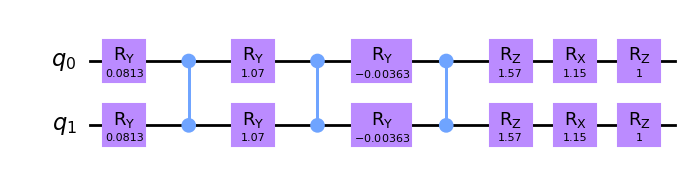

In [77]:
compiler.u.assign_parameters(compiler.thetas).draw("mpl")

In [43]:
num_qubits = 2
num_layers = 1
qsp = QuantumStatePreparation(
    u=ansatz.g2gn(num_qubits, num_layers),
    target_state=u,
).fit()

In [46]:
a = np.array(np.random.uniform(size=2**3))
a = np.array(a)
print(a)

[0.1479254  0.35385336 0.46256374 0.04863633 0.87661814 0.85051769
 0.17240042 0.03764264]


In [48]:
from qsee.compilation.qsp import QuantumStatePreparation

target_state = np.array(np.random.uniform(size=2**3))
compiler = QuantumStatePreparation.prepare(target_state, error_rate=0.1)

Default compiler is not sastify your error rate, please use other ansatz in QuantumCompilationObj


**Important**, you must save the result in the folder experiments/qsp/, where the 'state' argument is the name of state which is need to prepare. The name of file will be automatically create followed this format:

```
[state]_[ansatz]_[num_qubits]_[num_layers].qspobj
```

Last step, load QSP from saved file and check its properties.

In [36]:
qspobj = QuantumStatePreparation.load("../experiments/test")
qspobj.fidelity

0.9998482451406707

In [8]:
obj = QuantumStatePreparation.prepare("ghz", num_qubits=3)

     ┌──────────────┐                ┌──────────────┐      ┌──────────────┐   
q_0: ┤ Ry(theta[0]) ├───────■────────┤ Ry(theta[3]) ├────■─┤ Ry(theta[6]) ├─■─
     ├──────────────┤       │        ├──────────────┤    │ ├──────────────┤ │ 
q_1: ┤ Ry(theta[1]) ├───────■────────┤ Ry(theta[4]) ├─■──┼─┤ Ry(theta[7]) ├─■─
     ├──────────────┤┌──────────────┐└──────────────┘ │  │ ├──────────────┤ │ 
q_2: ┤ Ry(theta[2]) ├┤ Ry(theta[5]) ├─────────────────■──■─┤ Ry(theta[8]) ├─■─
     └──────────────┘└──────────────┘                      └──────────────┘   
can prepare the state ghz 3 qubits >= 0.99 fidelity (0.9998482451406707)


In [35]:
obj.save("../experiments/test")